In [2]:
import pandas as pd

df = pd.read_csv("/content/metrics.csv")

df.head()

,timestamp,cpu_utilization,memory_utilization,network_in,network_out
0,2025-01-01 00:00:00,37.48,52.46,106.43,97.42
1,2025-01-01 00:05:00,34.31,52.28,113.89,99.41
2,2025-01-01 00:10:00,38.24,44.23,108.05,101.16
3,2025-01-01 00:15:00,42.62,53.02,122.21,117.04
4,2025-01-01 00:20:00,33.83,59.40,143.94,86.55


In [3]:
import pandas as pd

# Drop timestamp column
df_no_time = df.drop(columns=['timestamp'])


In [4]:
num_df = df_no_time.select_dtypes(include=['int64', 'float64'])

In [5]:
corr_matrix = num_df.corr(method='pearson')
corr_matrix

,cpu_utilization,memory_utilization,network_in,network_out
cpu_utilization,1.000000,-0.005617,-0.004074,0.133935
memory_utilization,-0.005617,1.000000,-0.006016,-0.014705
network_in,-0.004074,-0.006016,1.000000,0.017017
network_out,0.133935,-0.014705,0.017017,1.000000


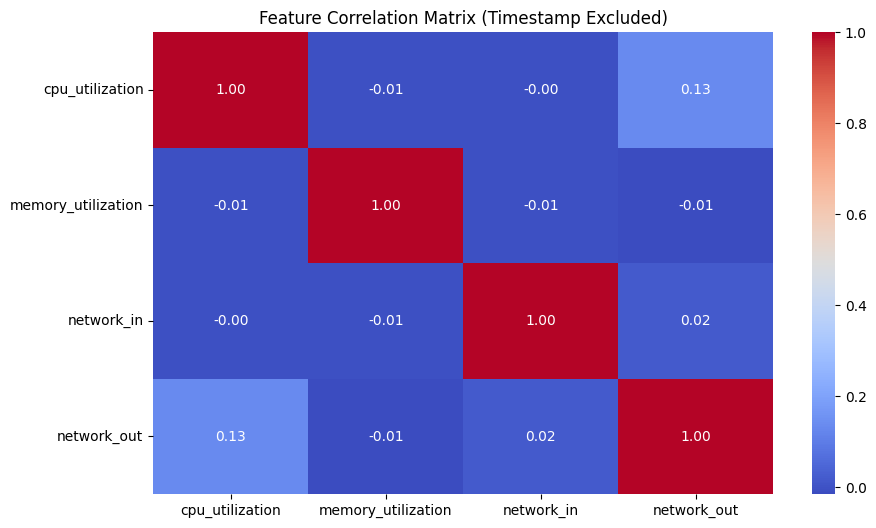

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix (Timestamp Excluded)")
plt.show()

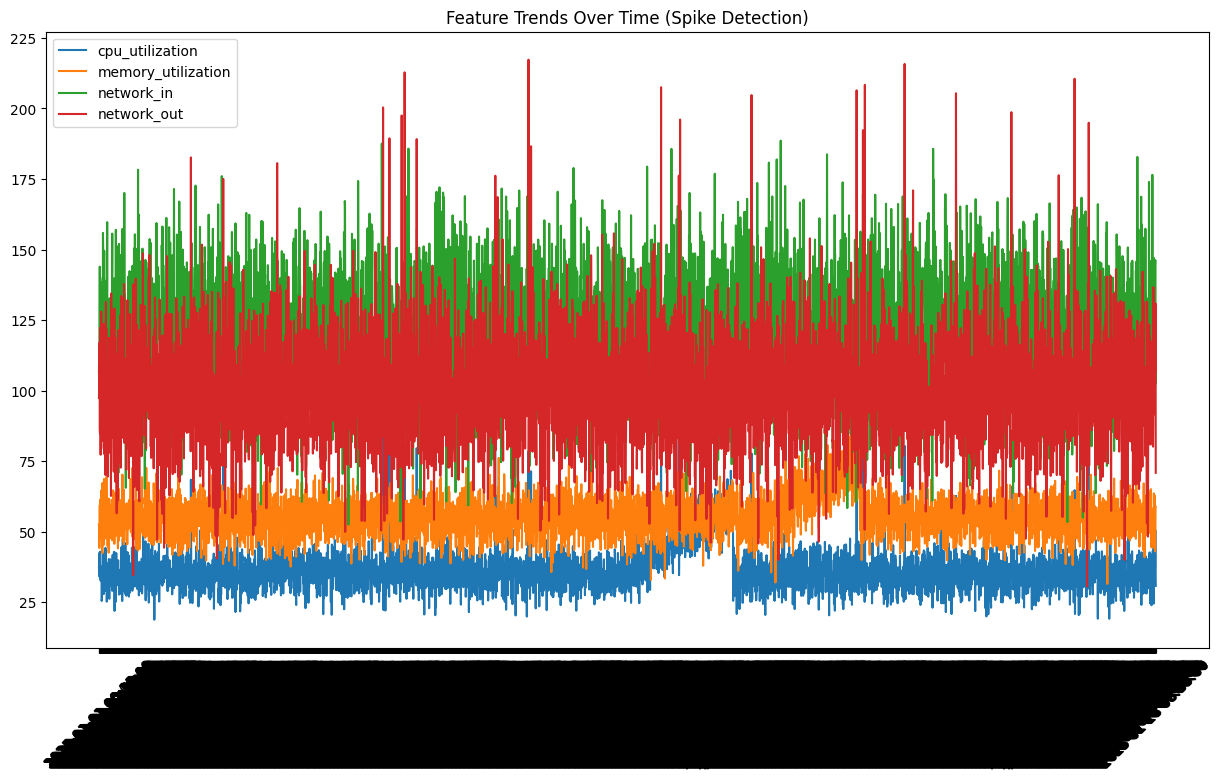

In [7]:
import matplotlib.pyplot as plt

# Sort by time
df_sorted = df.sort_values("timestamp")

# Plot each numeric feature
num_cols = df_sorted.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15, 8))
for col in num_cols:
    plt.plot(df_sorted["timestamp"], df_sorted[col], label=col)

plt.legend()
plt.title("Feature Trends Over Time (Spike Detection)")
plt.xticks(rotation=45)
plt.show()

In [8]:
from scipy.stats import zscore
import numpy as np

z_scores = np.abs(zscore(df_sorted[num_cols]))
spikes = (z_scores > 3)

spike_counts = spikes.sum(axis=0)
spike_counts

array([89, 45, 18, 31])

In [9]:
# Rows where ANY feature spikes
spike_rows = df_sorted[spikes.any(axis=1)]

spike_rows.head()

,timestamp,cpu_utilization,memory_utilization,network_in,network_out
162,2025-01-01 13:30:00,40.79,54.45,125.66,34.57
435,2025-01-02 12:15:00,68.41,51.32,123.59,182.66
558,2025-01-02 22:30:00,36.97,54.82,117.95,40.46
588,2025-01-03 01:00:00,82.66,62.12,127.97,175.01
735,2025-01-03 13:15:00,37.36,53.31,55.35,127.81


In [10]:
import pandas as pd

spike_counts = pd.Series(
    spikes.sum(axis=0),
    index=num_cols
)

spike_feature = spike_counts.idxmax()
spike_feature

'cpu_utilization'

In [11]:
spike_mask = spikes[:, num_cols.get_loc(spike_feature)]

normal_data = df_sorted.loc[~spike_mask, num_cols]
spike_data = df_sorted.loc[spike_mask, num_cols]

impact = spike_data.mean() - normal_data.mean()
impact.sort_values(ascending=False)

,0
network_out,30.779047
cpu_utilization,30.223345
memory_utilization,-0.376445
network_in,-2.379163


Task **2**(APPROACH1)


In [12]:
df.shape ##small dataset

(5000, 5)

In [13]:
df.info()## only timstamp column is timeseries rest all are tabular

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           5000 non-null   object 
 1   cpu_utilization     5000 non-null   float64
 2   memory_utilization  5000 non-null   float64
 3   network_in          5000 non-null   float64
 4   network_out         5000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 195.4+ KB


In [14]:
df.head()

,timestamp,cpu_utilization,memory_utilization,network_in,network_out
0,2025-01-01 00:00:00,37.48,52.46,106.43,97.42
1,2025-01-01 00:05:00,34.31,52.28,113.89,99.41
2,2025-01-01 00:10:00,38.24,44.23,108.05,101.16
3,2025-01-01 00:15:00,42.62,53.02,122.21,117.04
4,2025-01-01 00:20:00,33.83,59.40,143.94,86.55


In [16]:
df.shape[1] ##less number of features

5

In [18]:
df.columns

Index(['timestamp', 'cpu_utilization', 'memory_utilization', 'network_in',
       'network_out'],
      dtype='object')

In [19]:
print(df.columns.tolist())

['timestamp', 'cpu_utilization', 'memory_utilization', 'network_in', 'network_out']


<Axes: xlabel='cpu_utilization', ylabel='Count'>

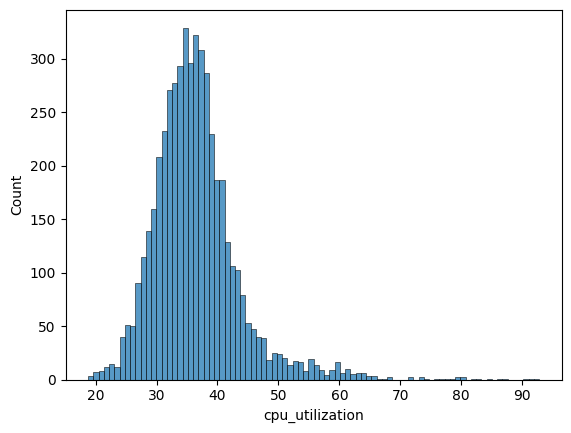

In [23]:
sns.histplot(df['cpu_utilization'])

<Axes: xlabel='memory_utilization', ylabel='Count'>

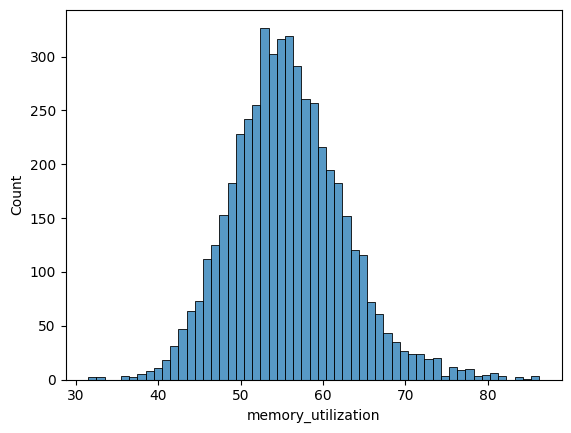

In [25]:
sns.histplot(df['memory_utilization'])

<Axes: xlabel='network_in', ylabel='Count'>

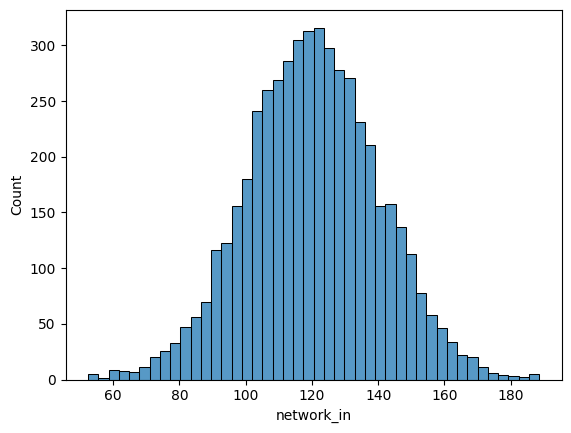

In [26]:
sns.histplot(df['network_in'])

<Axes: xlabel='network_out', ylabel='Count'>

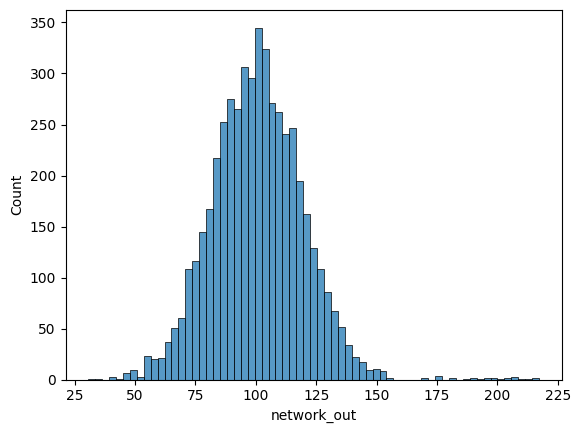

In [27]:
sns.histplot(df['network_out'])

In [28]:
df['cpu_utilization'].skew()

np.float64(1.7656320692407417)

In [29]:
df['network_in'].skew()

np.float64(-0.00847117388864827)

In [30]:
df['network_out'].skew()

np.float64(0.5415812271789783)

In [31]:
df['memory_utilization'].skew()

np.float64(0.44833136660544676)

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
df = pd.read_csv("metrics.csv")

# Convert timestamp
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by time
df = df.sort_values("timestamp").reset_index(drop=True)

df.head()

,timestamp,cpu_utilization,memory_utilization,network_in,network_out
0,2025-01-01 00:00:00,37.48,52.46,106.43,97.42
1,2025-01-01 00:05:00,34.31,52.28,113.89,99.41
2,2025-01-01 00:10:00,38.24,44.23,108.05,101.16
3,2025-01-01 00:15:00,42.62,53.02,122.21,117.04
4,2025-01-01 00:20:00,33.83,59.40,143.94,86.55


In [35]:
num_cols = [
    "cpu_utilization",
    "memory_utilization",
    "network_in",
    "network_out"
]

In [36]:
window_size = 30

In [37]:
rolling_mean = df[num_cols].rolling(window=window_size).mean()
rolling_std  = df[num_cols].rolling(window=window_size).std()

In [38]:
upper_bound = rolling_mean + (3 * rolling_std)
lower_bound = rolling_mean - (3 * rolling_std)

In [39]:
anomalies = (df[num_cols] > upper_bound) | (df[num_cols] < lower_bound)

In [40]:
anomaly_rows = df[anomalies.any(axis=1)]

anomaly_rows.head()

,timestamp,cpu_utilization,memory_utilization,network_in,network_out
157,2025-01-01 13:05:00,37.37,72.51,107.55,116.08
162,2025-01-01 13:30:00,40.79,54.45,125.66,34.57
209,2025-01-01 17:25:00,54.26,55.37,106.23,98.63
435,2025-01-02 12:15:00,68.41,51.32,123.59,182.66
588,2025-01-03 01:00:00,82.66,62.12,127.97,175.01


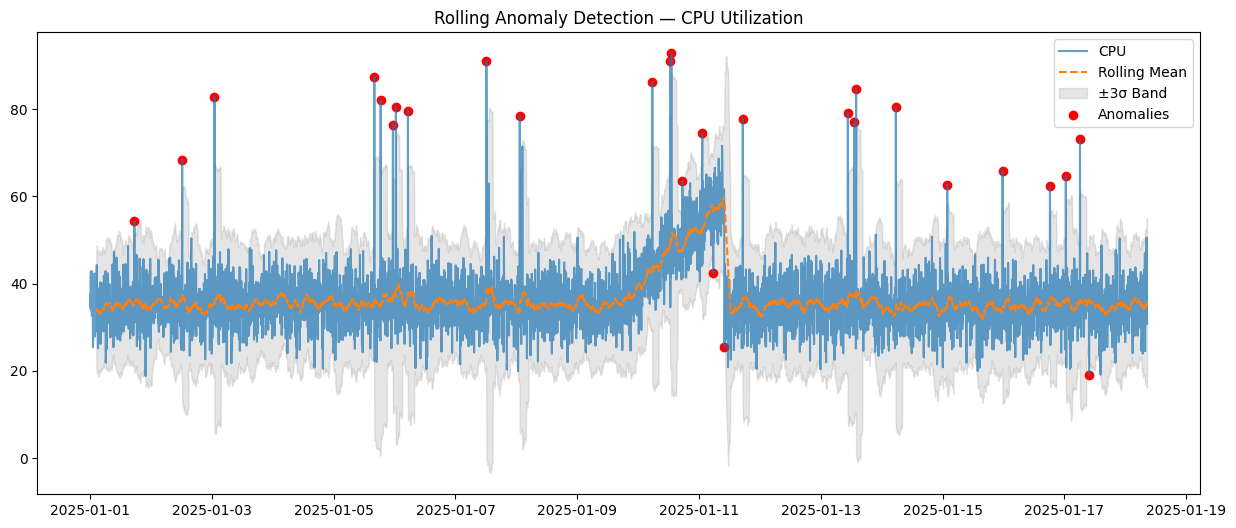

In [43]:
plt.figure(figsize=(15,6))

# Main CPU line
plt.plot(
    df["timestamp"],
    df["cpu_utilization"],
    label="CPU",
    alpha=0.7
)

# Rolling mean
plt.plot(
    df["timestamp"],
    rolling_mean["cpu_utilization"],
    linestyle="--",
    label="Rolling Mean"
)

# ±3σ band
plt.fill_between(
    df["timestamp"],
    lower_bound["cpu_utilization"],
    upper_bound["cpu_utilization"],
    color="gray",
    alpha=0.2,
    label="±3σ Band"
)

# ✅ FIX: Use timestamp instead of index
cpu_anomaly_points = df[anomalies["cpu_utilization"]]

plt.scatter(
    cpu_anomaly_points["timestamp"],
    cpu_anomaly_points["cpu_utilization"],
    color="red",
    label="Anomalies"
)

plt.legend()
plt.title("Rolling Anomaly Detection — CPU Utilization")
plt.show()

In [44]:
import matplotlib.pyplot as plt

def plot_rolling_anomalies(df, feature, rolling_mean, lower, upper, anomalies):

    plt.figure(figsize=(15,6))

    # Main metric line
    plt.plot(
        df["timestamp"],
        df[feature],
        label=feature,
        alpha=0.7
    )

    # Rolling mean
    plt.plot(
        df["timestamp"],
        rolling_mean[feature],
        linestyle="--",
        label="Rolling Mean"
    )

    # ±3σ band
    plt.fill_between(
        df["timestamp"],
        lower[feature],
        upper[feature],
        color="gray",
        alpha=0.2,
        label="±3σ Band"
    )

    # Anomaly points
    anomaly_points = df[anomalies[feature]]

    plt.scatter(
        anomaly_points["timestamp"],
        anomaly_points[feature],
        color="red",
        label="Anomalies"
    )

    plt.title(f"Rolling Anomaly Detection — {feature}")
    plt.legend()
    plt.show()

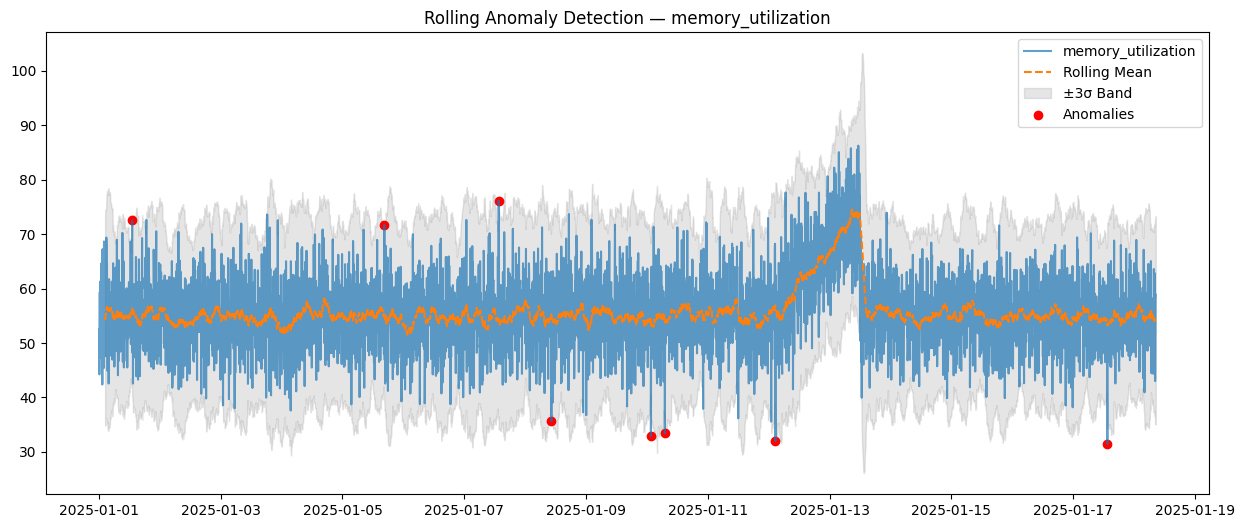

In [45]:
plot_rolling_anomalies(
    df,
    "memory_utilization",
    rolling_mean,
    lower_bound,
    upper_bound,
    anomalies
)

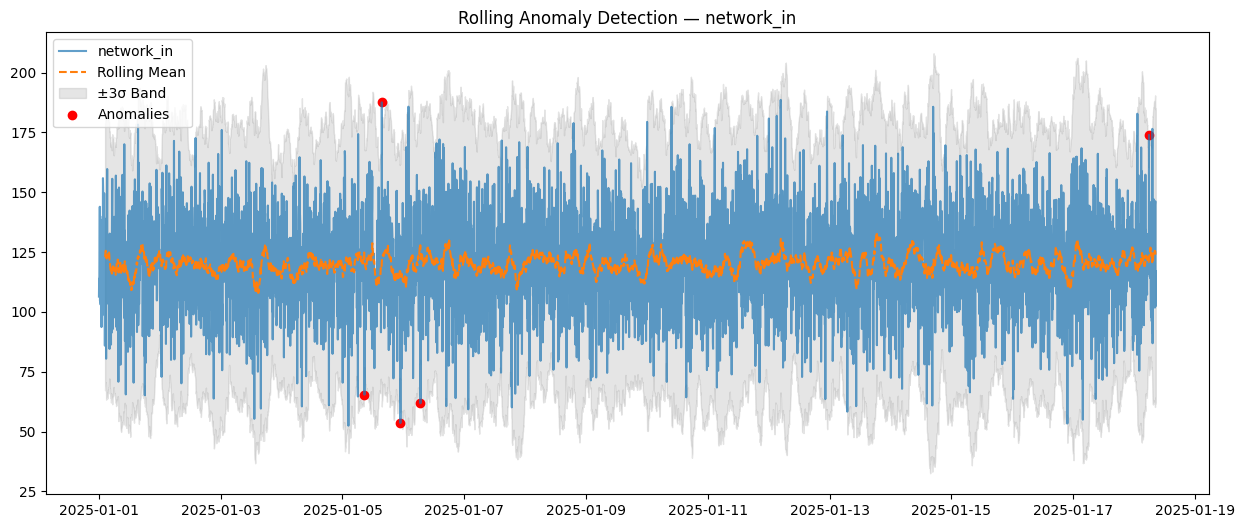

In [46]:
plot_rolling_anomalies(
    df,
    "network_in",
    rolling_mean,
    lower_bound,
    upper_bound,
    anomalies
)

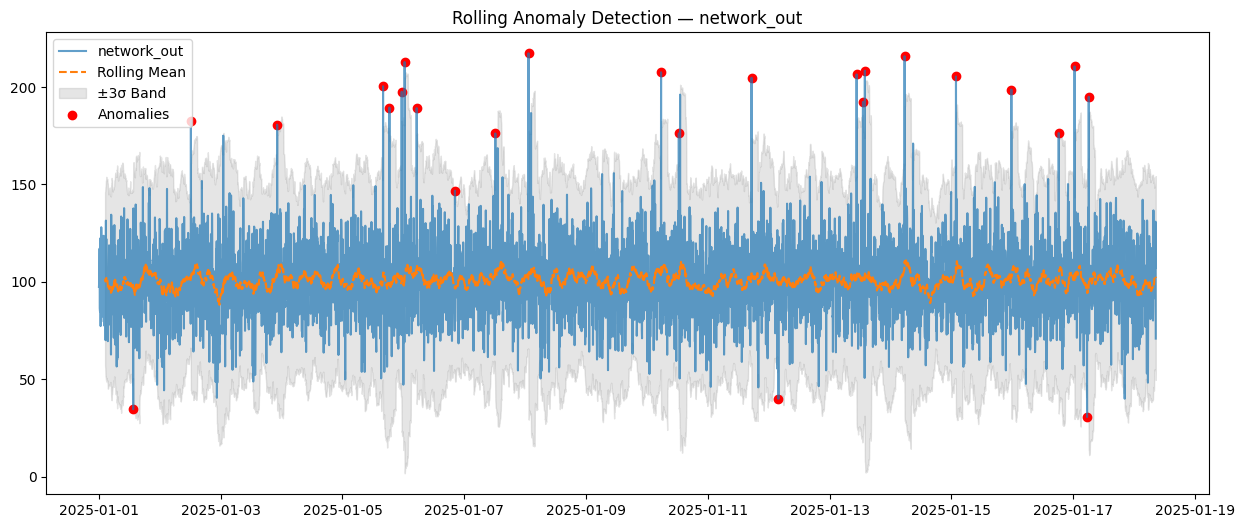

In [47]:
plot_rolling_anomalies(
    df,
    "network_out",
    rolling_mean,
    lower_bound,
    upper_bound,
    anomalies
)

Approach 2

In [48]:
features = [
    "cpu_utilization",
    "memory_utilization",
    "network_in",
    "network_out"
]

X = df[features]

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [50]:
from sklearn.ensemble import IsolationForest

iso_model = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42
)

iso_model.fit(X_scaled)

IsolationForest(contamination=0.01, random_state=42)

In [51]:
df["iso_label"] = iso_model.predict(X_scaled)

# Convert to boolean anomaly flag
df["iso_anomaly"] = df["iso_label"] == -1

df["iso_anomaly"].value_counts()

,count
iso_anomaly,
False,4950
True,50


In [53]:
total_anomalies = df["iso_anomaly"].sum()

print("Total Isolation Forest anomalies:", total_anomalies)

Total Isolation Forest anomalies: 50


In [54]:
iso_anomalies = df[df["iso_anomaly"]]

iso_anomalies.head()

,timestamp,cpu_utilization,memory_utilization,network_in,network_out,iso_label,iso_anomaly
435,2025-01-02 12:15:00,68.41,51.32,123.59,182.66,-1,True
588,2025-01-03 01:00:00,82.66,62.12,127.97,175.01,-1,True
1344,2025-01-05 16:00:00,87.43,55.19,122.24,200.36,-1,True
1350,2025-01-05 16:30:00,29.15,71.68,93.17,53.78,-1,True
1374,2025-01-05 18:30:00,81.99,53.97,97.81,189.41,-1,True


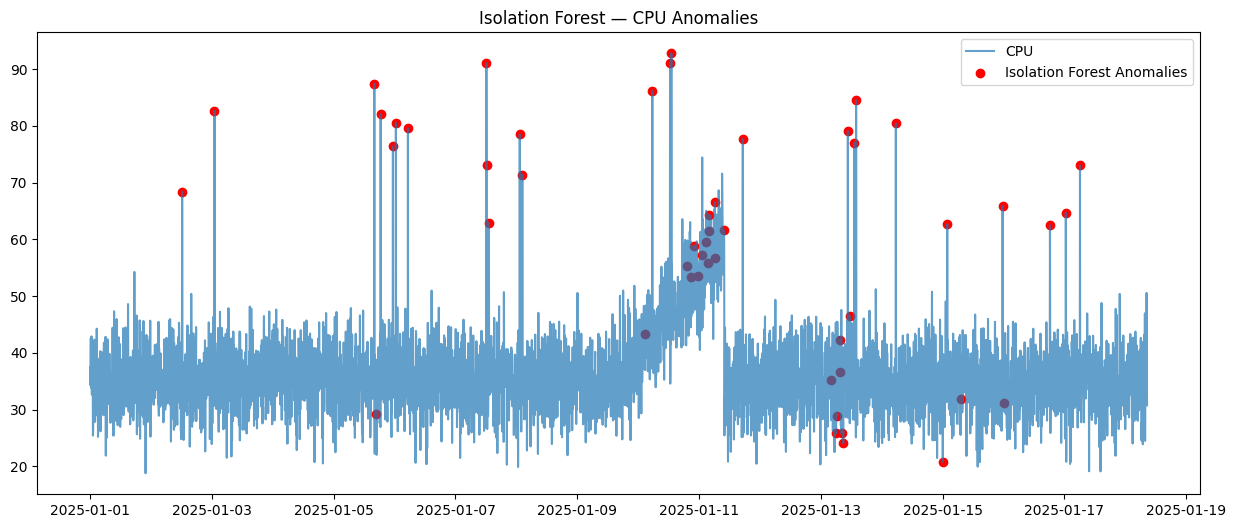

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

plt.plot(
    df["timestamp"],
    df["cpu_utilization"],
    label="CPU",
    alpha=0.7
)

plt.scatter(
    iso_anomalies["timestamp"],
    iso_anomalies["cpu_utilization"],
    color="red",
    label="Isolation Forest Anomalies"
)

plt.title("Isolation Forest — CPU Anomalies")
plt.legend()
plt.show()

In [59]:
import matplotlib.pyplot as plt

def plot_iso_anomalies(df, feature):

    plt.figure(figsize=(15,6))

    # Feature time series
    plt.plot(
        df["timestamp"],
        df[feature],
        label=feature,
        alpha=0.7
    )

    # Isolation Forest anomalies
    anomaly_points = df[df["iso_anomaly"]]

    plt.scatter(
        anomaly_points["timestamp"],
        anomaly_points[feature],
        color="red",
        label="Isolation Forest Anomalies"
    )

    plt.title(f"Isolation Forest — {feature} Anomalies")
    plt.legend()
    plt.show()

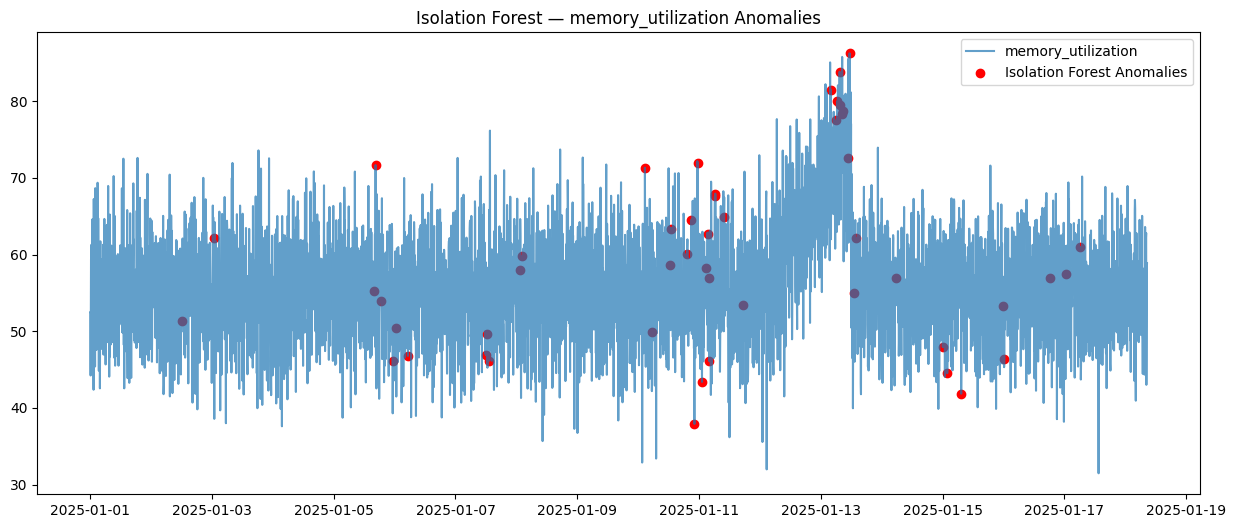

In [60]:
plot_iso_anomalies(df, "memory_utilization")

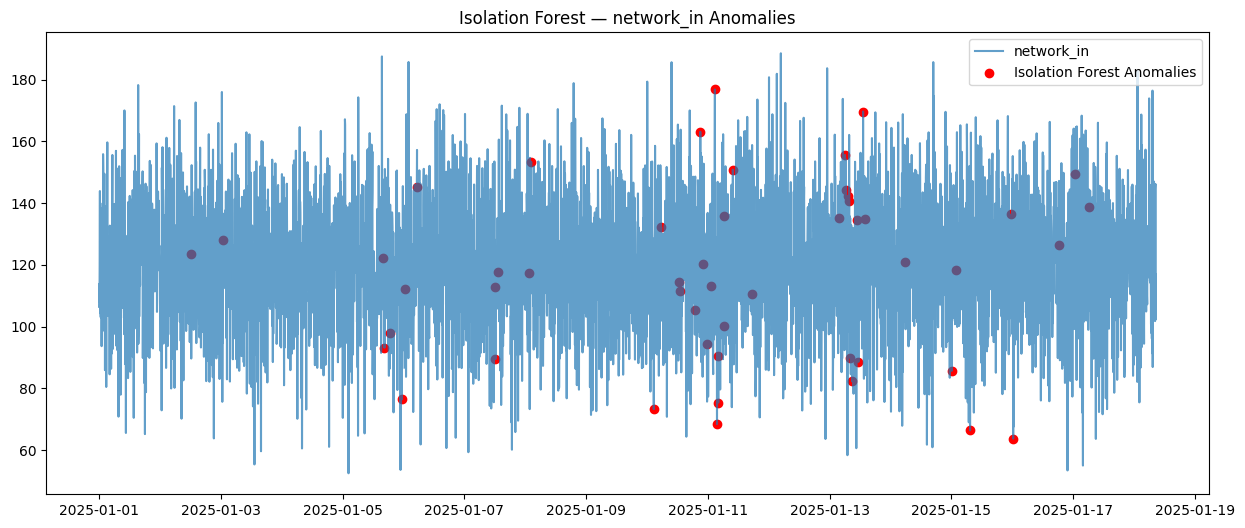

In [61]:
plot_iso_anomalies(df, "network_in")

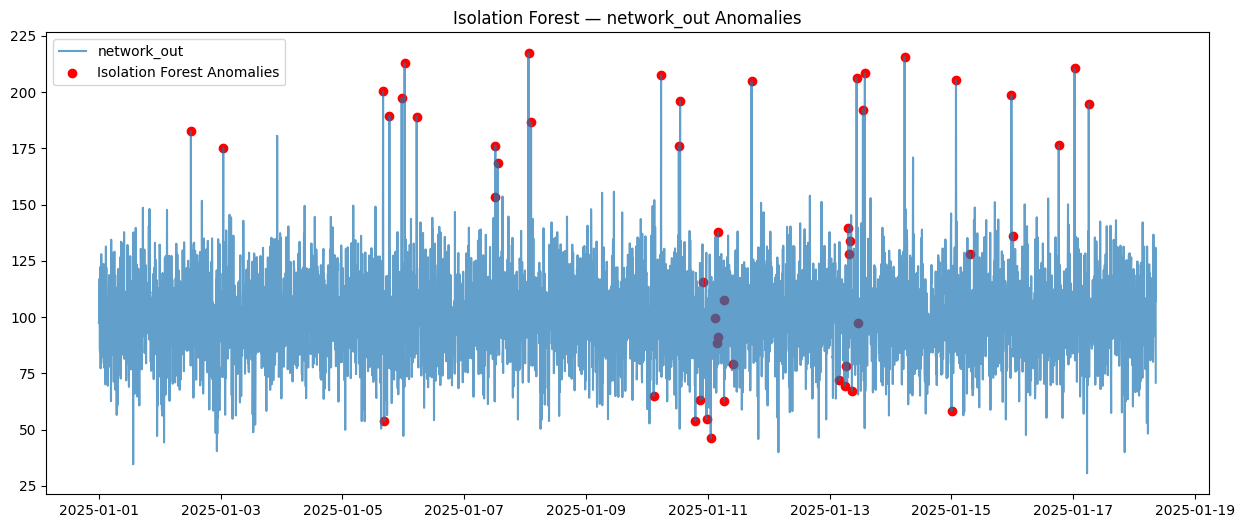

In [62]:
plot_iso_anomalies(df, "network_out")

Comparision between approaches

In [64]:

df["rolling_anomaly"] = anomalies.any(axis=1)

In [65]:
comparison_table = pd.crosstab(
    df["rolling_anomaly"],
    df["iso_anomaly"],
    rownames=["Rolling"],
    colnames=["IsolationForest"]
)

comparison_table

IsolationForest,False,True
Rolling,,
False,4927,26
True,23,24


In [66]:
total_rolling = df["rolling_anomaly"].sum()
total_iso = df["iso_anomaly"].sum()

both = ((df["rolling_anomaly"]) & (df["iso_anomaly"])).sum()
rolling_only = ((df["rolling_anomaly"]) & (~df["iso_anomaly"])).sum()
iso_only = ((~df["rolling_anomaly"]) & (df["iso_anomaly"])).sum()

print("Rolling anomalies:", total_rolling)
print("Isolation anomalies:", total_iso)
print("Both detected:", both)
print("Rolling only:", rolling_only)
print("Isolation only:", iso_only)

Rolling anomalies: 47
Isolation anomalies: 50
Both detected: 24
Rolling only: 23
Isolation only: 26


In [67]:
agreement = both / (total_rolling + total_iso - both)

print("Detection Agreement:", round(agreement * 100, 2), "%")

Detection Agreement: 32.88 %
